# Variational Autoencoders in JAX

This notebook shows how to build a deep Variational Autoencoder (VAE) with JAX, trained on the MNIST dataset. The implementation is inspired by a lecture about generative ML at the University of Toronto.

A VAE is a kind of autoencoder that outputs a probability distribution in the latent space, unlike their (unvariational) counterpart that outputs a single latent vector instead. Our VAE encoder, instead of learning a good encoding vector in the latent space, gives the parameters of a multidimensional isotropic Gaussian that can be used to sample encodings from the latent space.

A quick recap on the inner workings. For an input $x_i$ and it's low-dimensional, latent representation $z$ we approximate the true posterior $p(z \vert x_i) \approx q_{\Phi_i}(z \vert x_i) = \mathcal{N}(\mu_i, \sigma_i^2)$ by a multidimensional isotropic Gaussian parametrized by $\Phi_i = (\mu_i, \log \sigma_i)$. This is our encoder. We decode a latent representation $p_\theta(x \vert z)$ parameterized by $\theta$.

Ideally, we would train the network as to maximize the data log probability $\log p(x)$. This is of course intractable; hence maximizing the Evidence Lower Bound (ELBO) serves as our objective placebo. Minimizing the negative ELBO, we get as a loss function:
\begin{align}
\mathcal{L}(\Phi, \theta; x) = -\mathbb{E}_{z \sim q_{\Phi}}{\left[\log p_\theta(x \vert z) \right]} + KL \left( q_\Phi(z \vert x) \vert \vert p(z) \right)
\end{align}
where the second term denotes our divergence of the assumed Gaussian $q_\Phi$ from the true prior $p(z)$.

Now let's define the model we use for MNIST encoding. Our prior $p(z) = \mathcal{N}(0, I)$ is assumed to be standard Gaussian. The likelihood $p_\theta(x \vert z) = \text{Bernoulli}(\theta)$ will be a multidimensional binomial where we have a bernoulli parameter for each pixel. The posterior approximation $q_{\Phi_i}(z \vert x_i) = \mathcal{N}(\mu_i, \sigma_i^2I)$ is an isotropic Gaussian.

Now in the classic implementation of a VAE, we have a set of parameters $\Phi_i$ for each datapoint, creating a dependency of the number of parameters to the training data size. To circumvent this, we use Amortized Inference (AI) to reduce the number of model parameters. The idea of AI is that instead of having $\Phi_i$ for each datapoint, we have a single $\Phi$ that specifies the parameters of a Neural Networks that, given $x_i$, outputs us $\Phi_i$. So we get $q_{\Phi_i}(z \vert x_i) = \mathcal{N}(z \vert \mu_{\Phi}(x_i), \Sigma_{\Phi}(x_i))$ instead.

JAX will provide us with the necessary autodiff functionality; we use Adam for gradient-based optimization of $\theta$ and $\Phi$.

## Part 1: Preparations

Let us import the necessary packages first.

In [1]:
from jax import jit, grad, value_and_grad, lax, vmap, random
import jax.numpy as np
import jax.random
from jax.scipy.special import logsumexp
from jax.scipy.stats import norm
from jax.tree_util import register_pytree_node

from flax import linen as nn
import optax

import tensorflow_probability as tfp
import tensorflow_probability.substrates.jax.distributions as dists

#config.update("jax_debug_nans", True)

import matplotlib.pyplot as plt
from tqdm.auto import trange
from functools import partial
from random import randint   # simple python rnd

## Part 2: Data
First things first, get the data!

Each datapoint in the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) is a 28x28 grayscale image (i.e. pixels are values between 0 and 1) of a handwritten digit in $\{0 \dots 9\}$, and a label indicating which number.

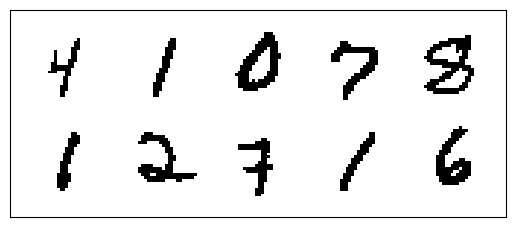

In [2]:
# Load MNIST data
import os
import gzip
import struct
import array
import matplotlib.image
from urllib.request import urlretrieve
import tensorflow_datasets as tfds

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)

def mnist():
    tfds_dataset, ds_info = tfds.load('mnist', split=['train', 'test'], shuffle_files=False, as_supervised=True, with_info=True)
    train, test = tfds_dataset
    train_images, train_labels = [], []
    test_images, test_labels = [], []
    for image, label in tfds.as_numpy(train):
        train_images.append(image)
        train_labels.append(label)
    for image, label in tfds.as_numpy(test):
        test_images.append(image)
        test_labels.append(label)
    return np.array(train_images), np.array(train_labels), np.array(test_images), np.array(test_labels)

def load_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(np.array(x.shape[1:]))))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels

N_data, train_images, train_labels, test_images, test_labels = load_mnist()

mean_image = np.mean(train_images, 0)


import numpy as onp   # original numpy
def plot_images(images, ims_per_row=5, padding=5, digit_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    """Images should be a (N_images x pixels) matrix."""
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = onp.int32(onp.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = onp.full(((digit_dimensions[0] + padding) * N_rows + padding,
                             (digit_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], digit_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + digit_dimensions[0]) * row_ix
        col_start = padding + (padding + digit_dimensions[1]) * col_ix
        concat_images[row_start: row_start + digit_dimensions[0],
                      col_start: col_start + digit_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(onp.array([]))
        plt.yticks(onp.array([]))
    
    plt.plot()

plot_images(train_images[:10, :])

## Part 3: Implement the VAE
Now that we have everything we need, we implement the Variational Autoencoder on binarized MNIST digits, as introduced by the paper [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf) by Kingma and Welling (2013). 

At first, some generic VAE funtions:

In [3]:
# Generic VAE functions.

def log_prior(z): 
    return np.sum(norm.logpdf(z, 0.0, 1.0), axis=-1)

def diag_gaussian_sample(rng, mean, log_std): 
  return mean + np.exp(log_std) * random.normal(rng, mean.shape) # single sample from a diagonal multivariate Gaussian

def diag_gaussian_logpdf(x, mean, log_std):
  return np.sum(vmap(norm.logpdf)(x, mean, np.exp(log_std))) # evaluate a single point on a diagonal multivariate Gaussian

def elbo(  # Single-sample Monte Carlo estimate of the variational lower bound.
    recognition_net,    # takes recognition_params and a datapoint, outputs mean and log_std of size latent_dim, i.e. log q(z|x)
    log_joint,          # takes likelihood_params and a vector of size latent_dim and a datapoint, outputs unnormalized log joint, i.e. log p(x,z)
    recognition_params, # Phi
    model_params,       # theta
    datapoint, rng):

  q_params = recognition_net(recognition_params, datapoint)  # get the approximate posterior parameters for dp using amotized inference
  mu, log_standarddev = q_params
  sample = diag_gaussian_sample(rng, mean=mu, log_std=log_standarddev)  # sample from approximate posterior.
  log_joint_value = log_joint(model_params, sample, datapoint) 
  log_post_value = diag_gaussian_logpdf(sample, mean=mu, log_std=log_standarddev) # Evaluates the density of log posterior q(z).
  
  # KL-divergence between two multidim. Gaussians
  d_kl = 0.5*(np.sum(np.exp(log_standarddev)) + np.dot(mu, mu) - datapoint.shape[0] - np.sum(log_standarddev)) 
  elbo_hat = log_joint_value - d_kl 
  return elbo_hat

def batch_elbo(recognition_net, log_joint, recognition_params, model_params, data, rng):   # batched version using JAX's vmap
  batch_size = data.shape[0]
  rngs = random.split(rng, batch_size)
  vectorized_elbo = vmap(partial(elbo, recognition_net, log_joint,
                                 recognition_params, model_params),
                         in_axes=(0, 0))
  return np.mean(vectorized_elbo(data, rngs)) # average ELBO estimate over a batch of samples


In [4]:
mean_image.shape

(784,)

Here we set the dimension of the latent space to 2.
A larger latent dimension would provide a more powerful model, but a dimension of two will make visualization and debugging easier.

Given the latent representation $z$ for an image, the distribution over all 784 pixels in the image is given by a product of independent Bernoullis, whose means are given by the output of a neural network $f_\theta(z)$:
$$p(x|z, \theta) = \prod_{d=1}^{784} \operatorname{Ber}(x_d|f_\theta(z)_d)$$
The neural network $f_\theta$ is called the decoder, and its parameters $\theta$ will be optimized to fit the data.

After each hundert iterations, we report the Evidence Lower Bound. 

In [5]:
# Define a VAE for the MNIST dataset
import jax.numpy as jnp
from jax.scipy.integrate import trapezoid

data_dimension = 28*28
latent_dimension = 2
key = random.PRNGKey(0)

class RecognitionNet(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=150)(x)
    x = nn.relu(x)
    x = nn.Dense(features=100)(x)
    x = nn.relu(x)
    mean = nn.Dense(features=latent_dimension)(x)   # Output mean of q(z)
    log_std = nn.Dense(features=latent_dimension)(x)   # Output log_std of q(z)
    return mean, log_std

class Decoder(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=150)(x)
    x = nn.relu(x)
    x = nn.Dense(features=100)(x)
    x = nn.relu(x)
    x = nn.Dense(features=100)(x)   # Output logit of Ber(x|z)
    x = nn.relu(x)
    x = nn.Dense(features=data_dimension*latent_dimension)(x)   # Output logit of Ber(x|z)
    return x.reshape((data_dimension, latent_dimension))

x_rand = random.normal(key, (data_dimension,))
z_rand = random.normal(key, (latent_dimension,))
init_recognition_params = RecognitionNet().init(key, x_rand)
init_decoder_params = Decoder().init(key, z_rand)

@jit
def nn_dynamics_general(time, params, x0,x):
  c = x0*(1-time) + x * time
  c_prime = x - x0
  jacobian = Decoder().apply(params,c)
  result = jacobian @ c_prime
  return result

@jit
def odenet(params, input):
  y0 = mean_image
  steps = 2500
  start_and_end_times = jnp.linspace(0.0, 1.0, steps)
  nn_dynamics = partial(nn_dynamics_general, x0=jnp.array([0.]*latent_dimension), x=input, params=params)
  ys = vmap(nn_dynamics)(start_and_end_times)
  result = trapezoid(ys, dx=1/steps, axis=0)
  out = y0+result
  return out


# Set up log likelihood function.
def bernoulli_logpdf(logits, x):
  return -np.sum(np.logaddexp(0., np.where(x, -1., 1.) * logits))   # Bernoulli log pdf of data x given logits

def log_likelihood(decoder_params, latent, datapoint):
  logits = odenet(decoder_params, latent)
  return bernoulli_logpdf(logits, datapoint)

def log_joint(decoder_params, latent, datapoint):
  return log_likelihood(decoder_params, latent, datapoint) + log_prior(latent)

# Run optimization
n_iters = 15000
minibatch_size = 64
optimizer = optax.adam(learning_rate=1e-3)
params = (init_recognition_params, init_decoder_params)
opt_state = optimizer.init(params)



@jax.jit
def objective(params, t):  # The loss function to be minimized.  
  rng = random.PRNGKey(t)
  minibatch_ixs = random.choice(key, train_images.shape[0], (minibatch_size,))
  minibatch =  train_images[minibatch_ixs, :]
  recognition_params, decoder_params = params 
  return -batch_elbo(RecognitionNet().apply, log_joint, recognition_params, decoder_params, minibatch, rng) 
  
def callback(params, t):
  if t % 100 == 0:
    print(f"Iteration {t}: ELBO {-objective(params, t)}")
  
@jax.jit
def step(params, opt_state, rnd):   
    gradient = grad(objective)(params, rnd)  # rnd used for random key in objective
    updates, opt_state = optimizer.update(gradient, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    params, opt_state = step(params, opt_state, t)
    callback(params, t)

recognition_params, decoder_params = params

Optimizing variational parameters...


  0%|          | 0/15000 [00:00<?, ?it/s]

Iteration 0: ELBO -178.14634704589844
Iteration 100: ELBO 211.26724243164062
Iteration 200: ELBO 245.07562255859375
Iteration 300: ELBO 264.1372985839844
Iteration 400: ELBO 277.509033203125
Iteration 500: ELBO 290.9166259765625
Iteration 600: ELBO 302.86859130859375
Iteration 700: ELBO 311.9376220703125
Iteration 800: ELBO 319.6977844238281
Iteration 900: ELBO 326.975830078125
Iteration 1000: ELBO 330.08172607421875
Iteration 1100: ELBO 336.38739013671875
Iteration 1200: ELBO 340.10791015625
Iteration 1300: ELBO 342.41668701171875
Iteration 1400: ELBO 345.72265625
Iteration 1500: ELBO 348.23101806640625
Iteration 1600: ELBO 349.95928955078125
Iteration 1700: ELBO 351.856201171875
Iteration 1800: ELBO 353.23565673828125
Iteration 1900: ELBO 354.9774169921875
Iteration 2000: ELBO 356.6197509765625
Iteration 2100: ELBO 358.53076171875
Iteration 2200: ELBO 360.600341796875
Iteration 2300: ELBO 361.56524658203125
Iteration 2400: ELBO 362.99749755859375
Iteration 2500: ELBO 364.377899169921

## Part 4: Investigate the Model

Great, model implementation and training has been completed! In what follows, we investigate our model by visualizing the distribution over data given by the generative model, sampling from it, and interpolating between digits.

One way to understand the meaning of latent representations is to see which parts of the latent space correspond to which kinds of data. Here we'll produce a scatter plot in the latent space, where each point in the plot represents a different image in the training set.

What we do here:

1.   Encode each image in the training set.
2.   Take the 2D mean vector of each encoding $q_\phi(z|x)$.
3.   Plot these mean vectors in the 2D latent space with a scatterplot.
4.   Colour each point according to the class label (0 to 9).


Hopefully our latent space will group images of different classes, even though we never provided class labels to the model. The latent structure has been learned by the model!





E1213 20:11:39.627804  456843 hlo_lexer.cc:443] Failed to parse int literal: 751131872138892745728275


(np.float64(-2.6884090483188627),
 np.float64(1.9230674088001252),
 np.float64(-2.4528192698955538),
 np.float64(1.5519535958766937))

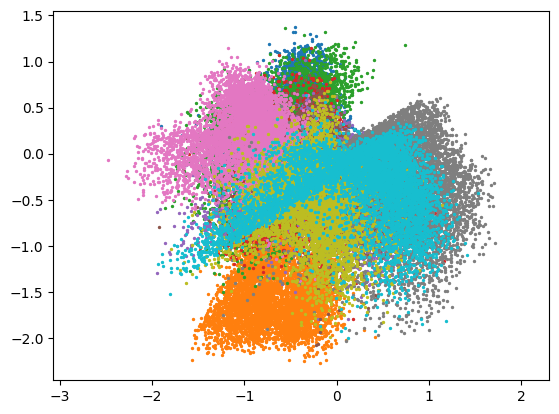

In [6]:
for k in range(10):
  cur_data = train_images[train_labels[:, k] == True, :]
  latent_mean, _ = RecognitionNet().apply(recognition_params, cur_data)
  plt.scatter(latent_mean[:, 0], latent_mean[:, 1], s=2)

plt.axis("equal")

But we can do more than that. A VAE is a generative model. We will generate some images by sampling from the prior in the latent space and decoding them to obtain artificial MNIST images.

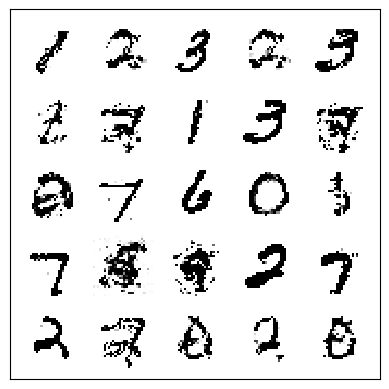

In [7]:
# Sample data from the trained generative model to see if it roughly matches the data.

def sigmoid(x):
  return 0.5 * (np.tanh(x) + 1.0)

recognition_params, decoder_params = params
n_samples = 25
sampled_zs = jax.random.normal(key, shape=(n_samples,latent_dimension)) # sample from prior on z.
vdecoder = vmap(odenet, in_axes=(None, 0))
bernoulli_means = sigmoid(vdecoder(decoder_params, sampled_zs)) # call decoder, and map logits to probabilities.
plot_images(bernoulli_means)

Another interesting way to examine a continuous latent variable model is to interpolate between the latent representations of two points. Here we will encode 3 pairs of data points with different classes. Then we will linearly interpolate between the mean vectors of their latent representation. We will plot the generative distributions along the linear interpolation.


1.   We write a function which takes two points $z_a$ and $z_b$, and a value $\alpha \in [0,1]$, and outputs the linear interpolation $z_\alpha = \alpha z_a + (1-\alpha)z_b$.
2.  Then we sample 3 pairs of images, each having a different class.
3.  Afterwards we encode the images in each pair, take the mean vectors and linearly interpolate them
4.  At 10 equally-space points along the interpolation, we show the Bernoulli means $p(x|z_\alpha)$.

In [8]:
def plot_interp(ix1, ix2):
  left_z = RecognitionNet().apply(recognition_params, train_images[ix1, :])[0]
  right_z = RecognitionNet().apply(recognition_params, train_images[ix2, :])[0]
  interp_weights = list(np.linspace(0.0, 1.0, 10))
  interp_zs = np.array([weight*left_z + (1.0-weight)*right_z for weight in interp_weights])  # Linearly interpolate between left_z and right_z
  bernoulli_means = sigmoid(vmap(odenet, in_axes=(None,0))(decoder_params, interp_zs))
  plot_images(bernoulli_means)

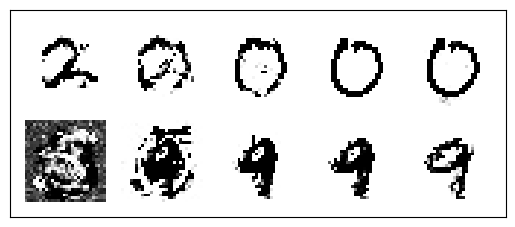

In [9]:
plot_interp(3, 11)

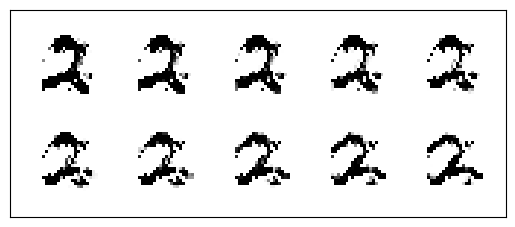

In [10]:
plot_interp(11, 22)

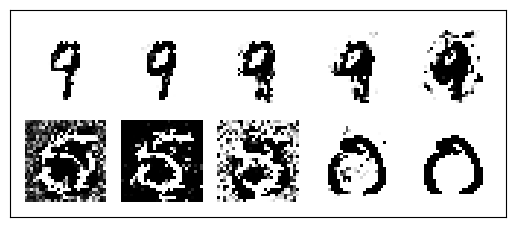

In [11]:
plot_interp(32, 334)

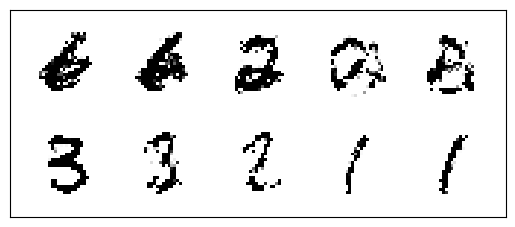

In [12]:
plot_interp(1, 2)

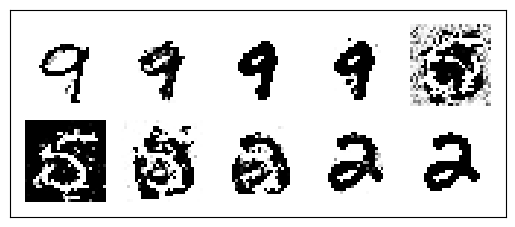

In [13]:
plot_interp(10, 12)